In [12]:
# import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce
import pickle
import json

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

# import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

In [13]:
%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
print(sys.version_info)
print(pd.__version__)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
0.24.2


In [15]:
all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
metjet_plot_vars = all_plot_vars[0:4] # ['metpt', 'jetpt', 'metjetphi', 'metmuphi']
muons_plot_vars = all_plot_vars[4:8] # ['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
cutflow_vars = ['cutflow_incl', 'cutflow_excl']
all_plot_xlabels = [
    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]'
]

In [16]:
with open('config/bkgs.json') as bkgs_json_file:
    bkgs = json.load(bkgs_json_file)

# Global muons

In [17]:
with open('data/histos_signal_objects_gbm.dat', 'rb') as file:
    histos_signal_from_file_gbm = pickle.load(file)

In [18]:
with open('data/histos_bkgs_objects_gbm.dat', 'rb') as file:
#with open('histos_bkgs_objects_gbm.dat', 'rb') as file:
    histos_bkgs_from_file_gbm = pickle.load(file)

In [19]:
luminosity = 59.97 * 1000 # 1/pb
for bkg, properties in bkgs.items():
    try:
        properties['weight'] = luminosity * properties['xsec'] / histos_bkgs_from_file_gbm['sumgenwgt'][bkg]
    except KeyError:
        properties['weight'] = 1

In [20]:
histos = {}
for plot_var in histos_bkgs_from_file_gbm:
    try:
        histos[plot_var] = {**histos_bkgs_from_file_gbm[plot_var], **histos_signal_from_file_gbm[plot_var]}
    except KeyError:
        histos[plot_var] = histos_bkgs_from_file_gbm[plot_var]

In [21]:
# Conversion from dict file into objects
# Shouldn't need this unless recovering from a broken Jupyter session
# histos_gbm = {}
# for var in histos_from_file_gbm:
#     histos_gbm[var] = {}
#     if 'cutflow' in var or 'genwgt' in var:
#         for bkg in histos_from_file_gbm[var]:
#             histos_gbm[var][bkg] = histos_from_file_gbm[var][bkg]
#     else:
#         for bkg in histos_from_file_gbm[var]:
#             histos_gbm[var][bkg] = HCont.HistogramContainer(bins=len(histos_from_file_gbm[var][bkg]['counts'][0]))
#             histos_gbm[var][bkg] += list(zip(histos_from_file_gbm[var][bkg]['counts'].values(),
#                                       {cut:histos_from_file_gbm[var][bkg]['edges'] for cut in numCuts}.values(),
#                                       histos_from_file_gbm[var][bkg]['wgt_sqrd'].values()))

### Cutflow table

In [22]:
cutflow_incl_grps = {}
for bkg, properties in bkgs.items():
    grp = properties['group']
    if grp not in cutflow_incl_grps:
        cutflow_incl_grps[grp] = (histos_bkgs_from_file_gbm['cutflow_incl'][bkg]*properties['weight']).astype(int)
    else:
        cutflow_incl_grps[grp] += (histos_bkgs_from_file_gbm['cutflow_incl'][bkg]*properties['weight']).astype(int)
        
# for mchi in ['5p25', '6p0', '52p5', '60p0']:
#     cutflow_incl_grps[mchi] = histos_signal_from_file_gbm['cutflow_incl'][mchi].astype(int)
        
pd.DataFrame.from_dict(cutflow_incl_grps)

,DY,QCD,TTbar,V+Jets,Di-boson
0,320515927,73223324490,30140886,213689064,310108
1,135564,1685736,1163196,7621102,22300
2,28611,228249,17433,2494019,1918
3,99,13629,202,6653,6
4,0,362,2,16,0
5,0,317,0,0,0


In [23]:
pd.DataFrame.from_dict(dict(sorted(histos['cutflow_incl'].items())))

,52p5,5p25,60p0,6p0,DYJetsToLL,QCD_bEnriched_HT1000to1500,QCD_bEnriched_HT100to200,QCD_bEnriched_HT1500to2000,QCD_bEnriched_HT2000toINF,QCD_bEnriched_HT200to300,...,WWTo2L2Nu,WZTo3LNu,ZJetsToNuNu_HT-100To200,ZJetsToNuNu_HT-1200To2500,ZJetsToNuNu_HT-200To400,ZJetsToNuNu_HT-2500ToInf,ZJetsToNuNu_HT-400To600,ZJetsToNuNu_HT-600To800,ZJetsToNuNu_HT-800To1200,ZZTo2L2Nu
0,85517.0,30655.0,73968.0,23622.0,100194597.0,493854.0,39349957.0,411724.0,401397.0,18684257.0,...,1091400.0,12600.0,24287910.0,343198.0,23760670.0,359639.0,9527919.0,5761094.0,2070653.0,8416200.0
1,27116.0,5806.0,21571.0,4681.0,42378.0,38685.0,17.0,73015.0,117599.0,275.0,...,28877.0,172.0,1357730.0,193395.0,6261875.0,243897.0,3731766.0,2542326.0,1013210.0,400836.0
2,19142.0,3984.0,13698.0,2844.0,8944.0,2432.0,3.0,3325.0,4521.0,55.0,...,4894.0,19.0,699334.0,12774.0,2283882.0,15368.0,636209.0,288523.0,87725.0,80654.0
3,5912.0,674.0,7824.0,1308.0,31.0,182.0,0.0,220.0,296.0,1.0,...,11.0,1.0,1577.0,193.0,7790.0,474.0,3626.0,2247.0,917.0,133.0
4,1187.0,89.0,3150.0,421.0,0.0,6.0,0.0,11.0,6.0,0.0,...,0.0,0.0,6.0,1.0,38.0,7.0,22.0,14.0,11.0,0.0
5,919.0,87.0,1499.0,420.0,0.0,5.0,0.0,4.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0


### Plots

In [24]:
def plot_binned_data_error(axis, bin_edges, data, wgt_sqrd, *args, **kwargs):
#     errors = []
    weights = np.empty(len(data))
#     errors = np.sqrt(np.sum(wgt_sqrd, axis=0))
    errors = wgt_sqrd[0]
    for i in np.arange(1, len(wgt_sqrd)):
        errors = errors.add(wgt_sqrd[i], fill_value=0)
    errors = errors.reindex(np.arange(1, len(bin_edges)), fill_value=0)
    errors = np.sqrt(errors)
    binwidth = bin_edges[1] - bin_edges[0]
#         if 'density' in kwargs and kwargs['density'] == True:
#             errors = errors/np.sum(data)/binwidth
        #The dataset values are the bin centres
    x = (bin_edges[1:] + bin_edges[:-1]) / 2.0
        #The weights are the y-values of the input binned data
#         weights[i] = data[i]
    return skh_plt.hist(x, ax=axis, bins=bin_edges, weights=np.sum(data, axis=0), errorbars=errors, *args, **kwargs)

In [25]:
def plot_stacked_binned_data(axis, bin_edges, data, wgt_sqrd, *args, **kwargs):
    errors = wgt_sqrd[0]
    for i in np.arange(1, len(wgt_sqrd)):
        errors = errors.add(wgt_sqrd[i], fill_value=0)
    errors = np.sqrt(errors)
    errors = np.array(errors.reindex(np.arange(1, len(bin_edges)), fill_value=0))
    #The dataset values are the bin centres
    x = (bin_edges[1:] + bin_edges[:-1]) / 2.0
    x = np.array([x]).repeat(len(data), axis=0)
    x = np.transpose(x)
    #The weights are the y-values of the input binned data
    weights = np.transpose(data)
    return skh_plt.hist(x, ax=axis, bins=bin_edges, weights=weights, errorbars=errors, stacked=True, *args, **kwargs)

In [26]:
from skhep.visual import MplPlotter as skh_plt

In [27]:
from collections import OrderedDict

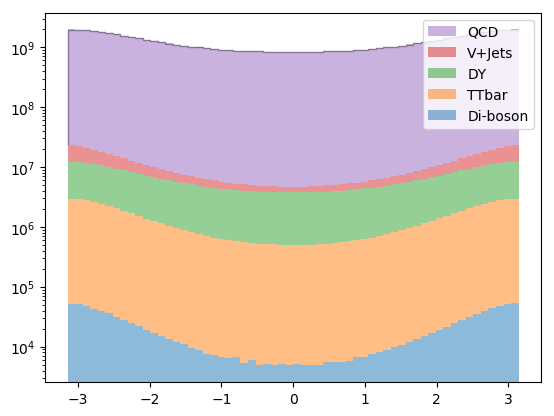

In [29]:
plot_var = 'metjetphi'
cut=0
labels = []
grp_histos = {}
for bkg, properties in bkgs.items():
    grp = properties['group']
    if grp not in grp_histos:
        grp_histos[grp] = HCont.HistogramContainer()
    # self.histos[plot_var][bkg].set_weight(properties['weight'])
    # FIXME placeholder while H.C. doesn't have set_weight
    grp_histos[grp].counts[cut] += histos[plot_var][bkg].counts[cut] * properties['weight']
    grp_histos[grp].edges = histos[plot_var][bkg].edges
    grp_histos[grp].wgt_sqrd[cut] = grp_histos[grp].wgt_sqrd[cut].add(
        histos[plot_var][bkg].wgt_sqrd[cut] * properties['weight']**2, fill_value=0)
    
sorted_keys = sorted(grp_histos, key=lambda obj: max(grp_histos[obj].counts[0]))
sorted_grp_histos = OrderedDict()
for key in sorted_keys:
#     if 'DY' not in key: continue
    sorted_grp_histos[key] = grp_histos[key]
    labels.append(key)

fig, axis = plt.subplots()
plot_stacked_binned_data(axis, histos['metjetphi']['ZZTo2L2Nu'].edges,
                       np.array([sorted_grp_histos[grp].counts[0] for grp in sorted_grp_histos]),
                      [sorted_grp_histos[grp].wgt_sqrd[0] for grp in sorted_grp_histos], label=labels);

axis.set_yscale('log', nonposy='clip')
# axis.set_ylim(bottom = 1)

axis.legend()

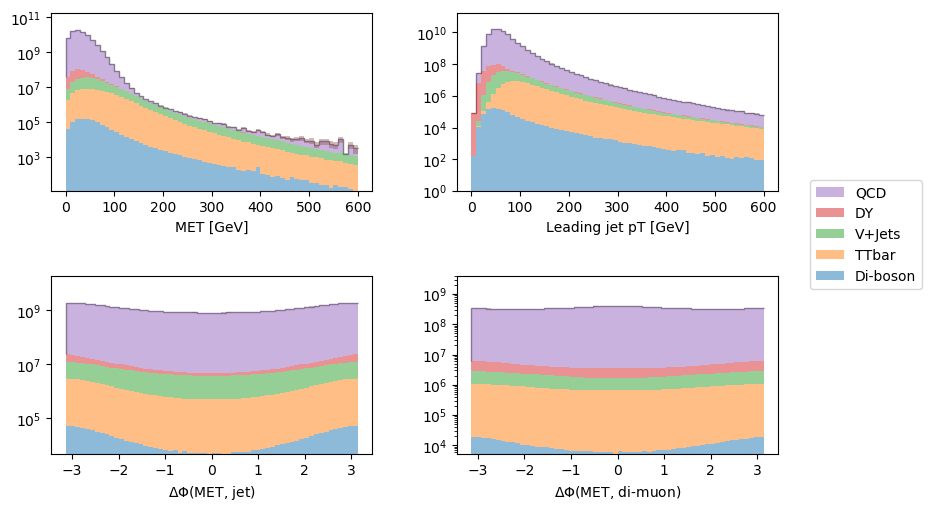

In [30]:
plt_maker = PM.PlotMaker(histos, bkgs)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)

for idx, var in enumerate(metjet_plot_vars):
    plt_maker.make_group_stacked_plot(axes1.flatten()[idx], var, 0, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
    
axes1[0,1].legend(loc=(1.1,-0.55));

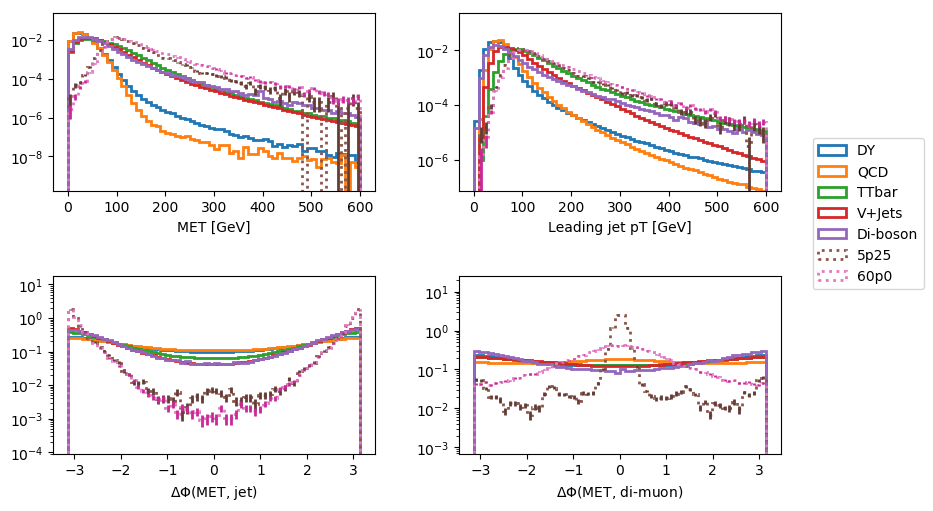

In [31]:
plt_maker = PM.PlotMaker(histos, bkgs, ['5p25', '60p0'])

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)

for idx, var in enumerate(metjet_plot_vars):
    plt_maker.make_group_plot(axes1.flatten()[idx], var, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
    
axes1[0,1].legend(loc=(1.1,-0.55));

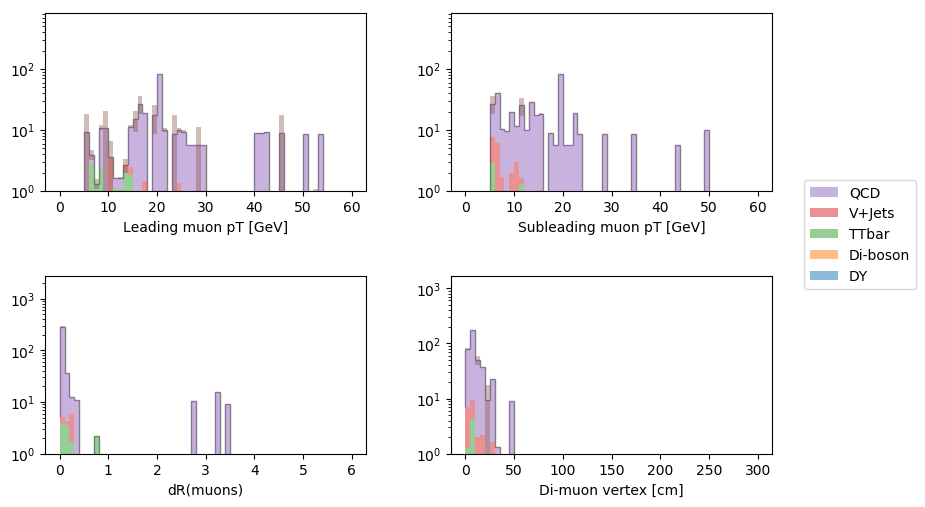

In [32]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(muons_plot_vars):
    plt_maker.make_group_stacked_plot(axes2.flatten()[idx], var, 4, log=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
    
axes2[0,1].legend(loc=(1.1,-0.55));

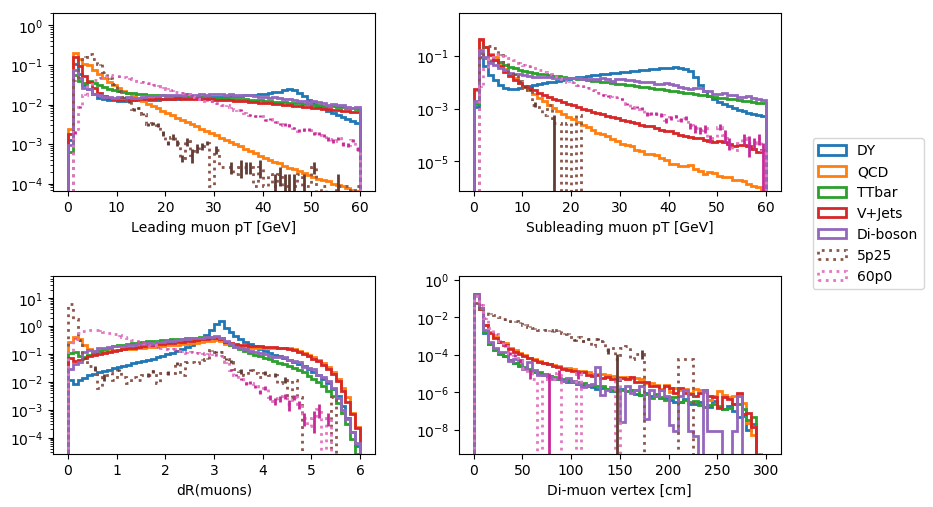

In [33]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(muons_plot_vars):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
    
axes2[0,1].legend(loc=(1.1,-0.55));

NameError: name 'plot_vars_muons' is not defined

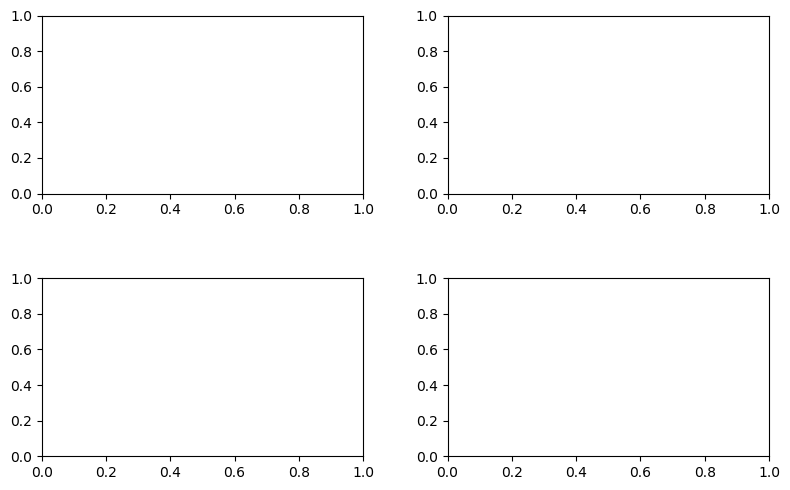

In [34]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_muons):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
axes2[0,1].legend(loc=(1.1,-0.55));

# Displaced standalone muons

In [35]:
with open('data/histos_objects_dsa.dat', 'rb') as histos_file:
    histos_from_file_dsa = pickle.load(histos_file)

In [36]:
plt_maker = PM.PlotMaker(histos_from_file_dsa)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_metjet):
    plt_maker.make_group_plot(axes1.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
axes1[0,1].legend(loc=(1.1,-0.55));

TypeError: __init__() missing 1 required positional argument: 'bkgs'

NameError: name 'plot_vars_muons' is not defined

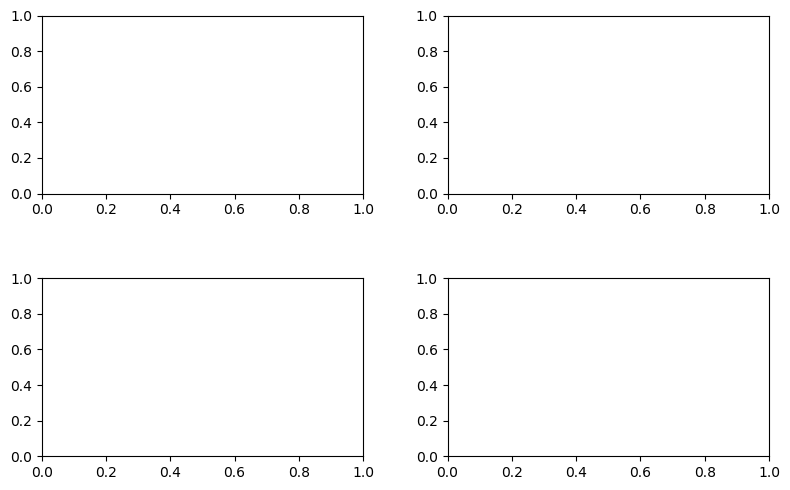

In [37]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_muons):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
axes2[0,1].legend(loc=(1.1,-0.55));